One-day-ahead stock price prediction program using LSTM recurrent neural network, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

# General libraries

In [1]:
# Importing the numpy library (for arrays operations)
# Importing the pandas library (for data analysis)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We retrieve the data of Netflix stock prices from 04/04/2013 to 04/04/2022 ("NFLX Historical Data.csv") from investing.com:<br>
https://www.investing.com/equities/netflix,-inc.-historical-data

In [2]:
# Storing the data in DataFrame "df", sorted by date in ascending order

df = pd.read_csv('NFLX Historical Data.csv')
df = df[::-1]
df

,Date,Price,Open,High,Low,Vol.,Change %
2268,"Apr 04, 2013",23.81,23.91,24.30,23.40,34.46M,-1.81%
2267,"Apr 05, 2013",23.52,23.36,24.36,23.22,32.52M,-1.22%
2266,"Apr 08, 2013",23.29,23.69,23.76,22.71,31.76M,-0.98%
2265,"Apr 09, 2013",24.19,23.36,24.48,23.15,34.08M,3.86%
2264,"Apr 10, 2013",23.72,24.00,24.21,23.56,29.73M,-1.94%
...,...,...,...,...,...,...,...
4,"Mar 29, 2022",391.82,384.39,396.50,380.33,5.81M,3.52%
3,"Mar 30, 2022",381.47,389.55,392.70,378.63,4.00M,-2.64%
2,"Mar 31, 2022",374.59,383.59,384.00,373.61,4.12M,-1.80%
1,"Apr 01, 2022",373.47,376.80,380.87,368.50,4.64M,-0.30%


In [3]:
# Storing "Open" values of stock prices in a numpy array "arr", and reshaping it into a vertical array

arr = df['Open'].values
arr = arr.reshape(-1, 1)
arr.shape

(2269, 1)

In [4]:
# Splitting the data into a training set stored in array "arr_train" (first 80% of the rows of "arr")
# And a test set stored in array "arr_test" (last 20% of the rows of "arr")
# Storing in list "dates" the dates corresponding to "arr_test"

arr_train = arr[:int(arr.shape[0]*0.8)]
arr_test = arr[int(arr.shape[0]*0.8):]
dates = df['Date'].tolist()[int(arr.shape[0]*0.8):]

arr_train.shape, arr_test.shape, len(dates)

((1815, 1), (454, 1), 454)

We import the estimator "MinMaxScaler" from the sklearn.preprocessing module to rescale the data to a given range, typically the interval [0,1].<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Since of the stock prices at different time periods have different value ranges, we split the train data into windows and rescale to [0,1] in each window. We rescale the test data to [0,1] too, using the scaling parameters of the last window of train data (because we are not supposed to have access to test data).<br>
https://sebastianraschka.com/faq/docs/scale-training-test.html

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Setting a window size and rescaling to [0,1] the data of "arr_train" in each window

window = 605
for i in range(0, len(arr_train)-window, window):
    arr_train[i: i+window] = scaler.fit_transform(arr_train[i: i+window])

# Rescaling the last part of "arr_train" and rescaling "arr_test" with these rescaling parameters too

arr_train[i+window:] = scaler.fit_transform(arr_train[i+window:])
arr_test = scaler.transform(arr_test)

We define a function "create_sequences" which creates two numpy arrays "sequences" and "labels" given an array "arr" and a number of time steps "n". The 1D numpy array labels contains all the last values of arr, starting from the n-th value. The 2D numpy array sequences contains all the sequences of n consecutive values of arr.

In [6]:
def create_sequences(arr, n):
    sequences, labels = [], []
    for i in range(n, arr.shape[0]):
        sequences.append(arr[i-n: i, 0])
        labels.append(arr[i, 0])
    return np.array(sequences), np.array(labels)

In [7]:
# Setting a number of time steps n
# Using the function create_sequences to create the training set and test set for the model
# Storing in "dates" the list of dates corresponding to test_labels

n = 60
train_seqs, train_labels = create_sequences(arr_train, n)
test_seqs, test_labels = create_sequences(arr_test, n)
dates = dates[n:]

train_seqs.shape, train_labels.shape, test_seqs.shape, test_labels.shape, len(dates)

((1755, 60), (1755,), (394, 60), (394,), 394)

In [8]:
# Reshaping train_seqs and test_seqs into the 3D array needed for the LSTM input layer of the model
# The 3D array includes: number of rows, number of time steps and number of features (here 1 for "Open" values)

train_seqs = np.reshape(train_seqs, (train_seqs.shape[0], train_seqs.shape[1], 1))
test_seqs = np.reshape(test_seqs, (test_seqs.shape[0], test_seqs.shape[1], 1))

train_seqs.shape, test_seqs.shape

((1755, 60, 1), (394, 60, 1))

# RNN model

In [9]:
# Importing the "Sequential" class from the keras.models API (to group a linear stack of layers into a model)
# Importing the "load_model" function from the keras.models API (to load a model saved via model.save())
# Importing the "LSTM" class from the keras.layers API (to load the long short-term memory layer to be used)
# Importing the "Dense" class from the keras.layers API (to load the regular densely-connected NN layer to be used)
# Importing the "Dropout" class from the keras.layers API (to apply dropout to the input)

# See https://keras.io/api/models/ and https://keras.io/api/layers/

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

We define a RNN model which takes as input the stock prices of n consecutive days and gives as output a prediction of stock price at day n+1:

- we set the class of the model as Sequential.
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units
- we add a Dropout layer with frequency rate r_d
- we add a Dense layer with 1 output unit (the dimension of 1 stock price prediction)

In [10]:
units_ℓ = 128
r_ℓ = 0.2
r_d = 0.4

model = Sequential()
model.add(LSTM(units=units_ℓ, return_sequences=True, input_shape=(n, 1)))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ, return_sequences=True))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ))
model.add(Dropout(r_d))
model.add(Dense(units=1))

In [11]:
# Summary of the model, see https://keras.io/api/models/model/#summary-method

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

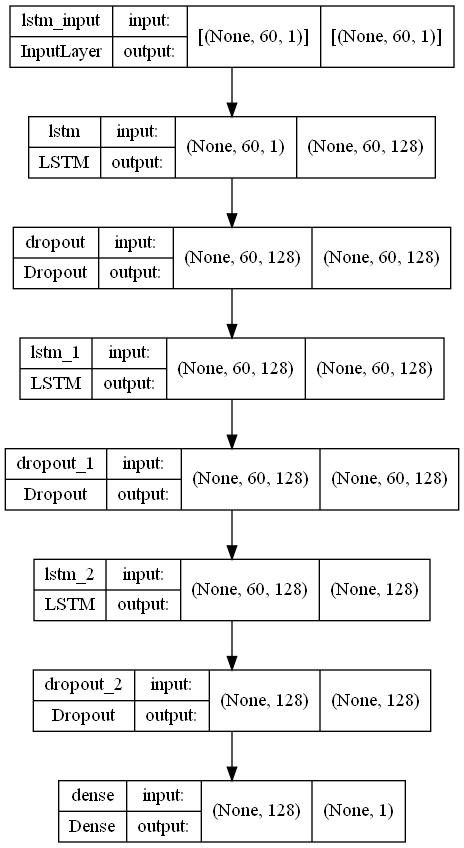

In [11]:
# Importing the "plot_model" function from keras.utils.vis_utils module (to plot a schema of the model)
# The "None" value stands for the (not yet defined) value of the batch size
# See https://keras.io/api/utils/model_plotting_utils/

from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We configure (compile) the model for training with:<br>
- mean square error (mse) between labels and predictions as quantity to minimise during training process
- root mean absolute error between labels and predictions as metric to display during training process
- "adam" as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)<br>
https://keras.io/api/optimizers/adam/

In [13]:
model.compile(loss='mse', optimizer='adam', metrics='RootMeanSquaredError')

We train the model with a given batch size and number of epochs. An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once (the default batch size in Keras is 32).<br>
https://keras.io/api/models/model_training_apis/#fit-method

For each epoch, we thus have
$$
\hbox{number of training steps} = \frac{\hbox{length of training set}}{\hbox{batch size}}\;\!.
$$

In [14]:
# Training the model and saving the model's attributes in a HDF5 file
# See https://en.wikipedia.org/wiki/Hierarchical_Data_Format

batch_size = 2
epochs = 15
model.fit(train_seqs, train_labels, batch_size=batch_size, epochs=epochs)
model.save('stock_price.h5')

Epoch 1/15


2022-05-08 16:42:49.559977: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


878/878 [==============================] - 18s 14ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141
Epoch 2/15
878/878 [==============================] - 12s 13ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874
Epoch 3/15
878/878 [==============================] - 12s 14ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707
Epoch 4/15
878/878 [==============================] - 12s 14ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679
Epoch 5/15
878/878 [==============================] - 12s 14ms/step - loss: 0.0048 - root_mean_squared_error: 0.0693
Epoch 6/15
878/878 [==============================] - 12s 14ms/step - loss: 0.0043 - root_mean_squared_error: 0.0657
Epoch 7/15
878/878 [==============================] - 13s 15ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632
Epoch 8/15
878/878 [==============================] - 14s 16ms/step - loss: 0.0034 - root_mean_squared_error: 0.0585
Epoch 9/15
878/878 [==============================] - 13s 15ms/step - loss:

In [15]:
# Storing in numpy array "predicted" the one-day-ahead stock prices predicted by the model
# Storing in numpy array "real" the real stock prices contained in "test_labels"
# Putting back both arrays to the original scale and format

model = load_model('stock_price.h5')

predicted = model.predict(test_seqs)
predicted = scaler.inverse_transform(predicted)
real = scaler.inverse_transform(test_labels.reshape(-1, 1))

# Visualisation of results

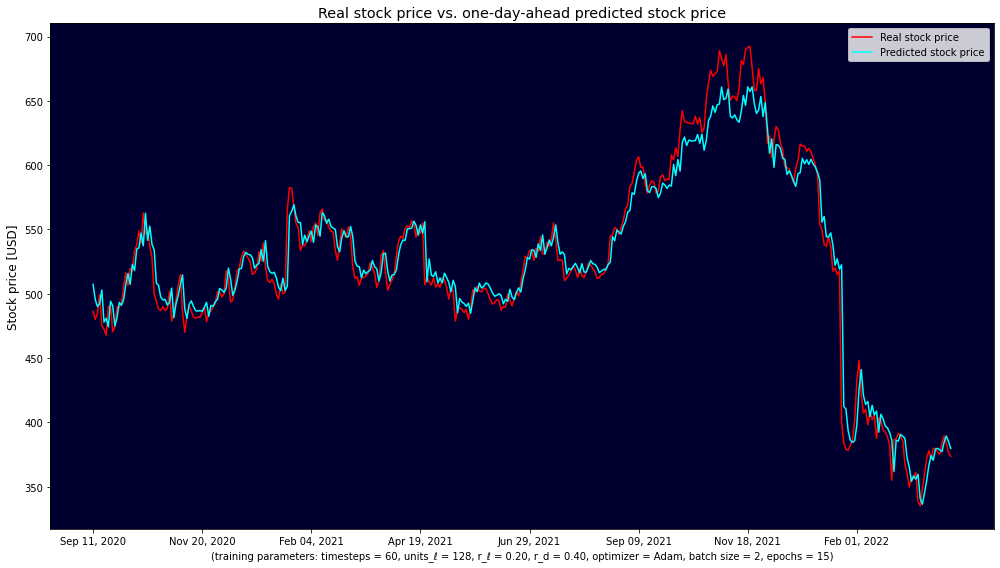

In [16]:
# Graph plot of real stock prices vs. one-day-ahead predicted stock prices

_, p = plt.subplots(figsize=(14,8))

p.plot(dates, real, color='r', label='Real stock price')
p.plot(dates, predicted, color='cyan', label='Predicted stock price')

# Parameters, title and legend of the plot

p.set_title('Real stock price vs. one-day-ahead predicted stock price', size='x-large')
p.set_ylabel('Stock price [USD]', size='large')
plt.xticks(np.arange(0, len(dates)+1, 50))
p.set_xlabel('(training parameters: timesteps = %d, units_ℓ = %d, r_ℓ = %.2f, r_d = %.2f, optimizer = Adam, batch size = %d, epochs = %d)'
             % (n, units_ℓ, r_ℓ, r_d, batch_size, epochs))
p.set_facecolor('#000030')
p.legend()

plt.tight_layout()